# sidebands

Python notebook to calculate the spectral sidebands in the optical output of a sinusoidally driven electro-optic phase modulator or Mach Zehnder interferometer.

In [1]:
from scipy.special import jv
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi,sin,cos,exp,abs

## Phase modulator

### Background

The electric field of a phase modulator when driven with sinusoidal voltage is

$$ E = E_0 \exp(i \omega_0 t) \exp(i \beta \sin \omega t) $$

where $\omega_0 = 2 \pi c / \lambda$ is the optical frequency, $\omega = 2 \pi f$ is the drive frequency, and $\beta = \pi V / V_{\pi}$ is the drive amplitude. Expanded in Bessel functions, we have

$$ E = E_0 \exp(i \omega_0 t) \sum_{n=-\infty}^{\infty} J_n(\beta) \exp(i n \omega t) $$

Defining $\omega_n \equiv \omega_0 + n \omega$,

$$ E = E_0 \sum_{n=-\infty}^{\infty} \exp(i \omega_n t) J_n(\beta) $$

The Bessel functions for negative $n$ satisfy $ J_{-n}(\beta) = (-1)^n J_n(\beta) $. Assuming intensity is equal to the field squared, the relative intensity $I_n$ of the sideband at $\omega_n$ is

$$ I_n = J_n^2(\beta) $$

which satisfies $\sum_{-\infty}^{\infty} I_n = 1$.

### Functions

In [2]:
def pmamplitude(n,beta): # sideband ampltude given n = sideband number, beta = pi*V/Vpi
    return jv(n,beta)
def pmintensity(n,beta): # sideband intensity given n = sideband number, beta = pi*V/Vpi
    return pmamplitude(n,beta)**2

We observe the calculated sideband intensities sum to one:

In [3]:
beta,N = 1.5,10
sum(pmintensity(n,beta) for n in range(-N,N+1))

0.9999999999999997

In [4]:
pmintensity(0,0)

1.0

### Sideband plots

A plot of $I_n$ as a function of drive voltage for the first few sidebands, assuming $V_\pi$ = 1 V:

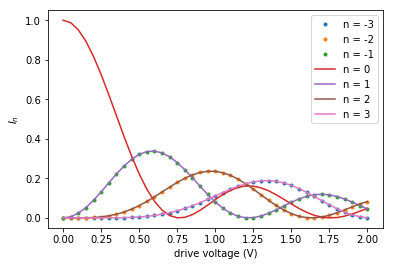

In [5]:
def pmsidebandplot(vpi,N=3):
    wx = np.linspace(0,2*vpi,41)
    for n in range(-N,N+1):
        plt.plot(wx, pmintensity(n,pi*wx/vpi), '.' if n<0 else '-', label=f'n = {n}')
    plt.legend(); plt.xlabel('drive voltage (V)'); plt.ylabel('$I_n$')
pmsidebandplot(vpi=1)

## Mach Zehnder Interferometer

### Background

The electric field at the output of an MZI is proportional to the sum of the fields in each leg

$$ E = E_0 \exp[i \omega_0 t + i \phi_0 + i \beta_0 \sin \omega t] + E_1 \exp[i \omega_0 t + i \phi_1 + i \beta_1 \sin \omega t] $$

after Bessel expansion we have

$$ E = \exp[i\omega_0 t] \sum_{n=-\infty}^{\infty} \exp[in\omega t] \left( E_0 \exp[i \phi_0] J_n(\beta_0) + E_1 \exp[i \phi_1] J_n(\beta_1) \right) $$

Defining $\omega_n \equiv \omega_0 + n \omega$,

$$ E = \sum_{n=-\infty}^{\infty} \exp[i\omega_nt] \left( E_0 \exp[i \phi_0] J_n(\beta_0) + E_1 \exp[i \phi_1] J_n(\beta_1) \right) $$

The relative intensity $I_n$ of the sideband at $\omega_n$ is

$$ I_n = \lvert E_0 \exp[i \phi_0] Jn(\beta_0) + E_1 \exp[i \phi_1] Jn(\beta_1) \rvert ^2 $$

$$ = E_0^2 J_n^2(\beta_0) + E_1^2 J_n^2(\beta_1) + 2 E_0 E_1 J_n(\beta_0) J_n(\beta_1) \cos \phi $$

where $ \phi =  \phi_1 -  \phi_0$

### Functions

In [6]:
def mzamplitude(n,E0,E1,phi,beta0,beta1): # Mach Zehnder sideband ampltude
    return E0*jv(n,beta0) + E1*jv(n,beta1)*exp(1j*phi)
def mzintensity(n,E0,E1,phi,beta0,beta1): # Mach Zehnder sideband intensity
    return E0**2*jv(n,beta0)**2 + E1**2*jv(n,beta1)**2 + \
        E0*E1*jv(n,beta0)*jv(n,beta1)*cos(phi)

### Temporal plots

The expected time dependent output of a balanced Mach Zehnder is

$$ I(t) = E_0^2 + E_1^2 + 2 E_0 E_1 \cos( \phi + \Delta \beta \sin \omega t ) $$

where $\Delta \beta = \beta_1 - \beta_0$.

In the following plot we find that this matches the time dependent output that we get from the infinite sum:

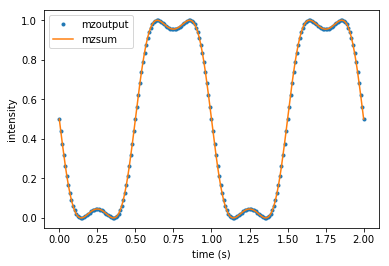

In [7]:
def mzoutput(E0,E1,phi,db,f,t):
    return E0**2 + E1**2 + 2*E0*E1*cos(phi+db*sin(2*pi*f*t))
def mzsum(E0,E1,phi,beta0,beta1,f,t,N=10):
    return abs(sum( exp(1j*2*pi*n*f*t) * mzamplitude(n,E0,E1,phi,beta0,beta1) for n in range(-N,N+1) ))**2
def timeplot(E0,E1,phi,beta0,beta1,f=1,N=None):
    wx = np.linspace(0,2/f,201)
    if N is None:
        wy = mzoutput(E0,E1,phi,beta1-beta0,f,wx)
        plt.plot(wx, wy, '.', label='mzoutput')
    else:
        wy = mzsum(E0,E1,phi,beta0,beta1,f,wx,N=N)
        plt.plot(wx, wy, '-', label='mzsum')
    plt.legend(); plt.xlabel('time (s)'); plt.ylabel('intensity')
timeplot(0.5, 0.5, pi/2, -1, +1)
timeplot(0.5, 0.5, pi/2, -1, +1, N=10)

It appears that, even if unbalanced, the time dependent output depends only on $\Delta \beta = \beta_1 - \beta_0$ and not the individual values of $\beta_0$ and $\beta_1$:

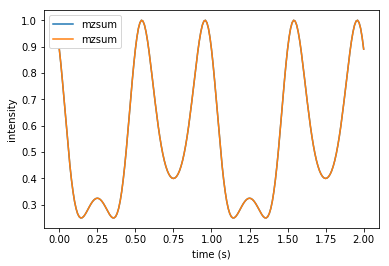

In [8]:
timeplot(0.25, 0.75, pi/4, beta0=-3, beta1=+0, N=10)
timeplot(0.25, 0.75, pi/4, beta0=-1, beta1=+2, N=10)

It also appears, however, that the sideband intensities depend individually on $\beta_0$ and $\beta_1$, not just their difference. We can see there is a difference by plotting a partial sum of the Bessel terms:

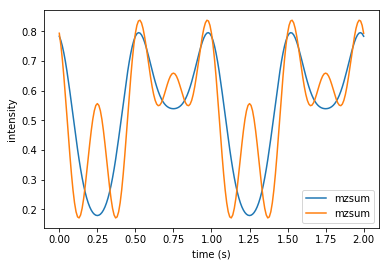

In [9]:
timeplot(0.25, 0.75, pi/4, beta0=-3, beta1=+0, N=2)
timeplot(0.25, 0.75, pi/4, beta0=-1, beta1=+2, N=2)

### Sideband plots

We see that the plot of sideband intensity as a function of drive voltage is the same as for the phase modulator, as long as the drive response is balanced (i.e. $\beta_1 = -\beta_0$) and the DC phase is at quadrature (choosing $V_\pi$ = 1 V for each leg):

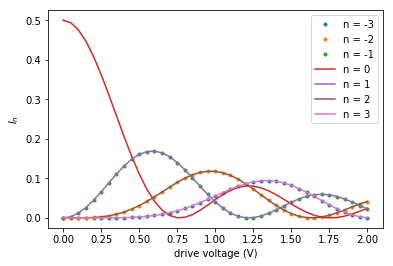

In [10]:
def mzsidebandplot(E0,E1,phi,vpi0=1,vpi1=1,N=3):
    wx = np.linspace(0,2*vpi0,41)
    for n in range(-N,N+1):
        wy = mzintensity(n,E0,E1,phi,beta0=-pi*wx/vpi0,beta1=+pi*wx/vpi1)
        plt.plot(wx, wy, '.' if n<0 else '-', label=f'n = {n}')
    plt.legend(); plt.xlabel('drive voltage (V)'); plt.ylabel('$I_n$')
mzsidebandplot(0.5, 0.5, pi/2)

The relative sideband strengths are also the same even if the fields in each arm are unbalanced:

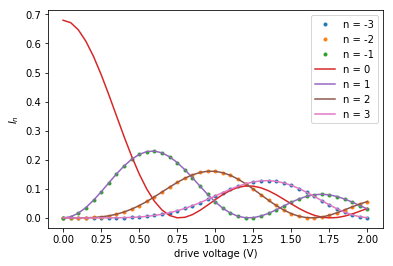

In [11]:
mzsidebandplot(0.2, 0.8, pi/2)

Something different emerges, however, if the Mach Zehnder is not at quadrature:

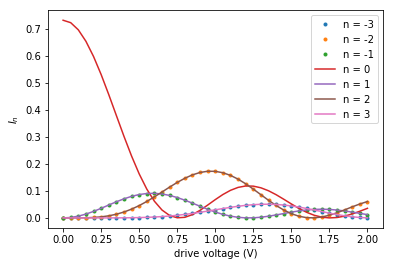

In [12]:
mzsidebandplot(0.5, 0.5, pi/8)

Note that it is always the case that the strength of the negative sideband is equal to its positive counterpart.

In [13]:
# %history # show all code